# Model Generation Code

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import os
import re
import nltk
import json
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from collections import Counter
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import corpus_bleu

# Assume Flickr8k dataset is in 'Flickr8k_Dataset' and captions in 'Flickr8k_text'
DATA_DIR = r'C:\UTA Curriculum\Sem 4\ML\Flickr8k_Kaggle\Images'
CAPTIONS_FILE = r'C:\UTA Curriculum\Sem 4\ML\Flickr8k_Kaggle\captions.txt'

def load_captions(captions_file):
    captions = {}
    with open(captions_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            tokens = line.split(',', 1)  # Split on the first comma only
            if len(tokens) < 2:
                print(f"Skipping line {line_number}: '{line}' (unexpected format)")
                continue
            image_id, caption = tokens[0], tokens[1]
            image_id = image_id.strip()
            caption = caption.strip()
            captions.setdefault(image_id, []).append(caption.lower())
    return captions

captions_dict = load_captions(CAPTIONS_FILE)
print(f"Total images with captions: {len(captions_dict)}")

# Print sample entries
for image_id, captions in list(captions_dict.items())[:5]:
    print(f"Image ID: {image_id}")
    for caption in captions:
        print(f" - {caption}")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {k: i for i, k in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        return nltk.tokenize.word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)
        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1



# FlickrDataset Class
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_dict, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.captions_dict = captions_dict
        self.transform = transform
        self.freq_threshold = freq_threshold
        
        self.image_ids = list(captions_dict.keys())
        self.captions_list = [caption for captions in captions_dict.values() for caption in captions]
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions_list)
        
        # Create list of (image_id, caption) pairs
        self.data = []
        for image_id, captions in captions_dict.items():
            for caption in captions:
                self.data.append((image_id, caption))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_id, caption = self.data[idx]
        image_path = os.path.join(self.root_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        numerical_caption = [self.vocab.stoi["<SOS>"]]
        numerical_caption += [self.vocab.stoi.get(token, self.vocab.stoi["<UNK>"]) 
                              for token in self.vocab.tokenizer(caption)]
        numerical_caption.append(self.vocab.stoi["<EOS>"])
        
        return image, torch.tensor(numerical_caption)

# Transforms and DataLoader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Standard ImageNet means
        std=[0.229, 0.224, 0.225]     # Standard ImageNet stds
    ),
])

dataset = FlickrDataset(root_dir=DATA_DIR, captions_dict=captions_dict, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])



def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    captions_padded = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=dataset.vocab.stoi["<PAD>"])
    return images, captions_padded, lengths

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


# 2. Model Architecture

# Pyramid Pooling Module
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super(PyramidPooling, self).__init__()
        self.pools = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1),
                nn.ReLU(inplace=True)
            )
            for pool_size in pool_sizes
        ])
    
    def forward(self, x):
        size = x.size()[2:]
        out = [x]
        for pool in self.pools:
            pooled = pool(x)
            upsampled = nn.functional.interpolate(pooled, size=size, mode='bilinear', align_corners=False)
            out.append(upsampled)
        return torch.cat(out, dim=1)



# P2T Encoder
class P2TEncoder(nn.Module):
    def __init__(self, embed_size):
        super(P2TEncoder, self).__init__()
        # Use a pretrained CNN backbone
        backbone = torchvision.models.resnet50(pretrained=True)
        modules = list(backbone.children())[:-2]  # Remove last fully connected layer
        self.backbone = nn.Sequential(*modules)
        
        self.ppm = PyramidPooling(in_channels=2048, pool_sizes=[1, 2, 3, 6])
        self.conv = nn.Conv2d(2048 + 2048 // 4 * 4, embed_size, kernel_size=1)
        self.bn = nn.BatchNorm2d(embed_size)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, images):
        features = self.backbone(images)
        features = self.ppm(features)
        features = self.conv(features)
        features = self.bn(features)
        features = self.relu(features)
        
        # Flatten the features to (batch_size, seq_len, embed_size)
        batch_size, embed_size, h, w = features.size()
        features = features.view(batch_size, embed_size, -1)  # (batch_size, embed_size, h*w)
        features = features.permute(0, 2, 1)  # (batch_size, seq_len, embed_size)
        return features

# Transformer Decoder
class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, heads, forward_expansion, dropout, max_len=100):
        super(CaptionDecoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_len, embed_size)
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, nhead=heads, dim_feedforward=forward_expansion*embed_size, dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.embed_size = embed_size
        self.max_len = max_len
        
    def forward(self, features, captions, lengths):
        batch_size = features.size(0)
        seq_length = captions.size(1)
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(device)
        
        captions = self.word_embedding(captions)
        captions += self.position_embedding(positions)
        captions = captions.permute(1, 0, 2)  # (seq_length, batch_size, embed_size)
        
        features = features.permute(1, 0, 2)  # (feature_length, batch_size, embed_size)
        
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(device)
        output = self.transformer_decoder(tgt=captions, memory=features, tgt_mask=tgt_mask)
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, embed_size)
        outputs = self.fc_out(output)
        return outputs

# Combine Encoder and Decoder
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, heads, forward_expansion, dropout):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = P2TEncoder(embed_size)
        self.decoder = CaptionDecoder(
            embed_size, vocab_size, num_layers, heads, forward_expansion, dropout
        )
    
    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# 3. Training Loop

# Hyperparameters
embed_size = 512
vocab_size = len(dataset.vocab)
num_layers = 3
heads = 8
forward_expansion = 4
dropout = 0.1
learning_rate = 1e-4
num_epochs = 10
average_loss = 0

# Initialize Model, Loss, Optimizer
model = ImageCaptioningModel(
    embed_size, vocab_size, num_layers, heads, forward_expansion, dropout
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, captions, lengths in tqdm(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1], lengths)
            outputs = outputs.reshape(-1, outputs.size(2))
            targets = captions[:, 1:].reshape(-1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        average_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")
        
        

# Start Training
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)



# 4. Evaluation

# Caption Generation Function
def generate_caption(model, image, vocab, max_length=50):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        outputs = torch.tensor([vocab.stoi["<SOS>"]]).unsqueeze(0).to(device)
        for _ in range(max_length):
            tgt = outputs
            positions = torch.arange(0, tgt.size(1)).unsqueeze(0).to(device)
            tgt_embedded = model.decoder.word_embedding(tgt) + model.decoder.position_embedding(positions)
            tgt_embedded = tgt_embedded.permute(1, 0, 2)
            features_transposed = features.permute(1, 0, 2)
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_embedded.size(0)).to(device)
            output = model.decoder.transformer_decoder(tgt_embedded, features_transposed, tgt_mask=tgt_mask)
            output = output.permute(1, 0, 2)
            output = model.decoder.fc_out(output[:, -1, :])
            predicted = output.argmax(1).unsqueeze(0)
            outputs = torch.cat([outputs, predicted], dim=1)
            if predicted.item() == vocab.stoi["<EOS>"]:
                break
        caption = [vocab.itos[idx.item()] for idx in outputs.squeeze()][1:]
        caption = ' '.join(caption)
        return caption



def evaluate_model(model, data_loader, vocab, num_images=5):
    model.eval()
    references = []
    hypotheses = []
    images_displayed = 0  # Counter for the number of images displayed
    with torch.no_grad():
        for images, captions, lengths in tqdm(data_loader):
            images = images.to(device)
            captions = captions.to(device)
            batch_size = images.size(0)
            for i in range(batch_size):
                image = images[i]
                caption_tensor = captions[i]
                generated_caption = generate_caption(model, image, vocab)
                
                # Convert ground-truth caption tensor to words
                ref_caption = [vocab.itos[idx.item()] for idx in caption_tensor if idx.item() not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}]
                references.append([ref_caption])
                hypotheses.append(generated_caption.split())
                
                # Display the image with ground-truth and predicted captions
                if images_displayed < num_images:
                    # Move the image tensor to CPU and convert to numpy
                    img = image.cpu().permute(1, 2, 0).numpy()
                    # Denormalize the image
                    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img = np.clip(img, 0, 1)
                    
                    # Plot the image and captions
                    plt.figure(figsize=(8, 8))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title('Ground Truth: ' + ' '.join(ref_caption) + '\n' + 'Predicted: ' + generated_caption)
                    plt.show()
                    
                    images_displayed += 1
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"BLEU Score: {bleu_score*100:.2f}")


# After training is complete
evaluate_model(model, val_loader, dataset.vocab, num_images=5)


# After training, when saving the model
MODEL_SAVE_PATH = 'image_captioning_modelv2.pth' 

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': average_loss,
    'vocab': dataset.vocab,
}, MODEL_SAVE_PATH)

# Using model "image_captioning_modelv2" on validation set

C:\Users\prana\AppData\Local\Temp\ipykernel_22556\1276921879.py:142: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location='cpu')
c:

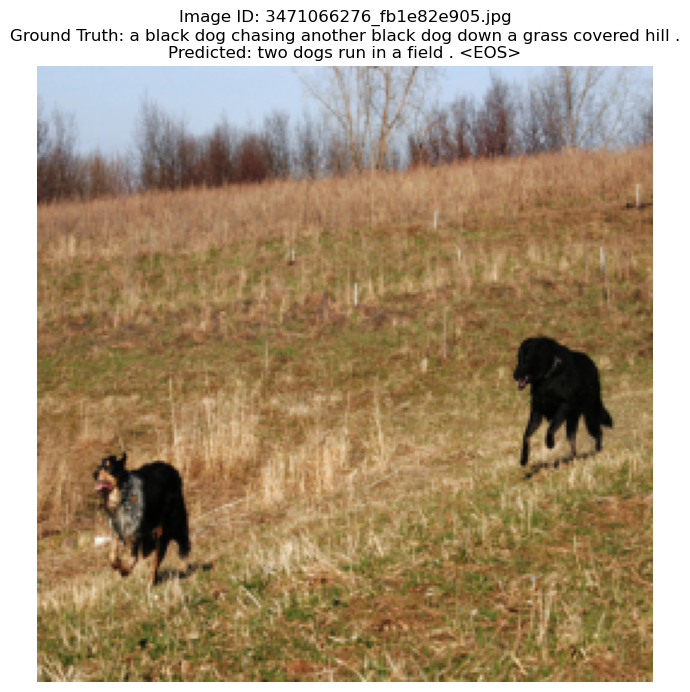

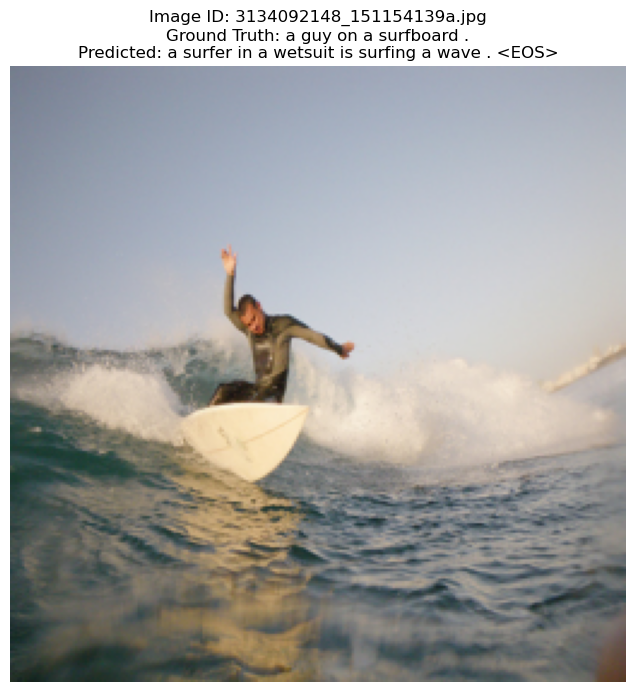

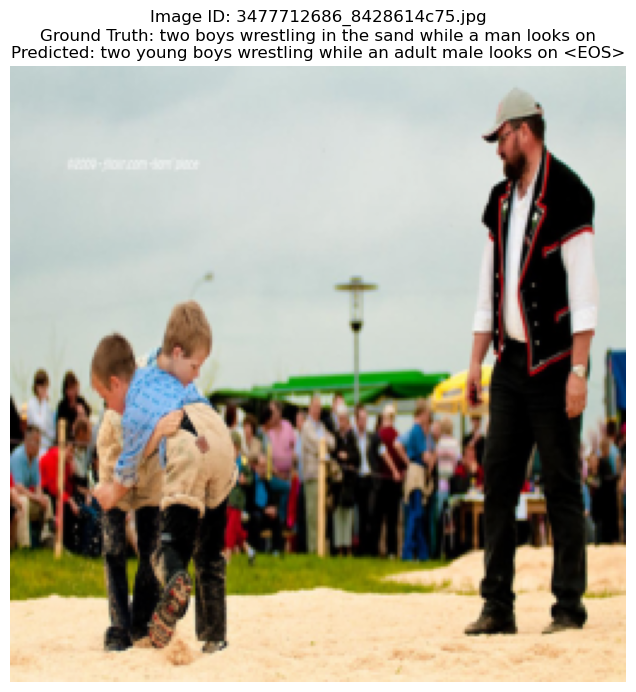

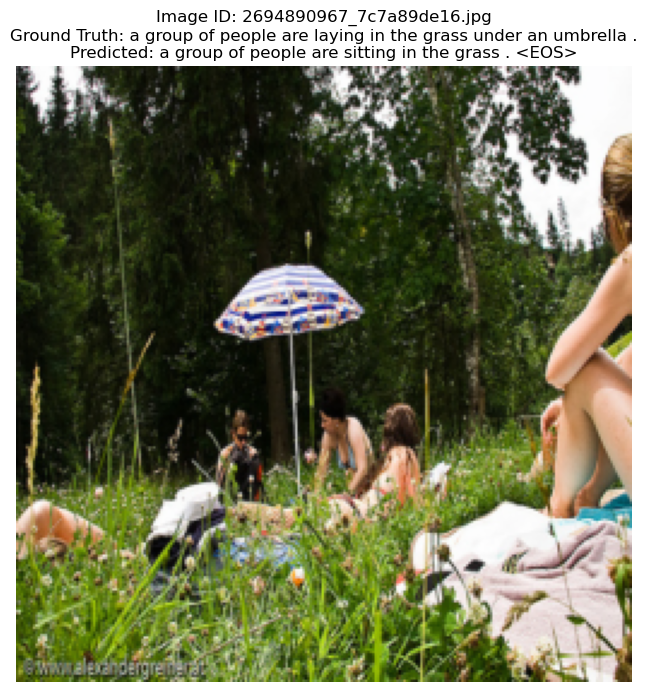

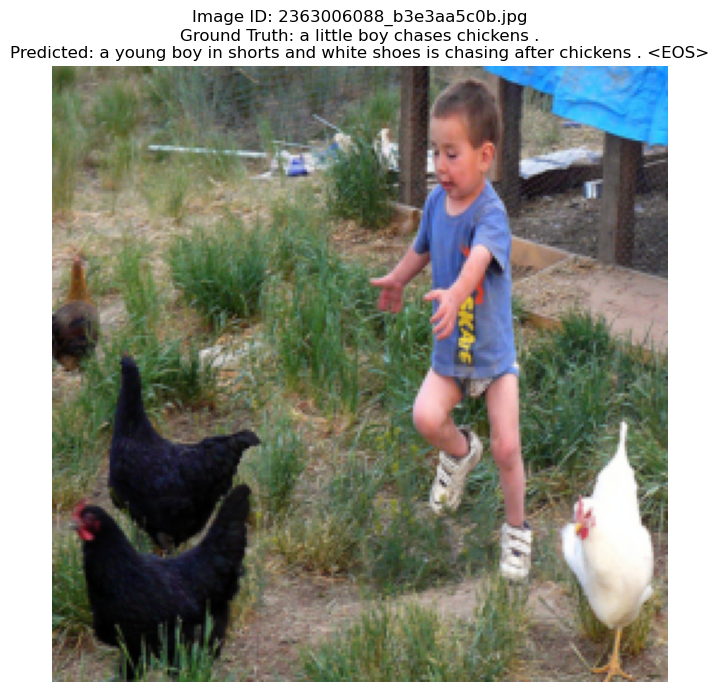

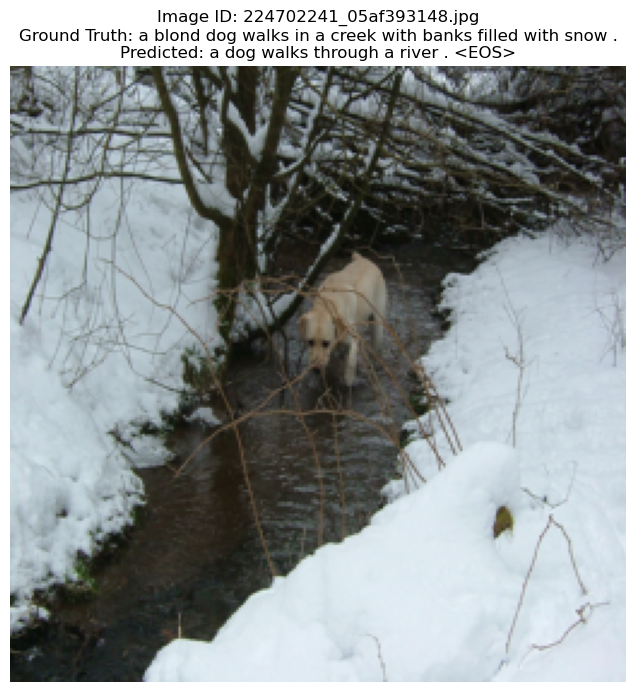

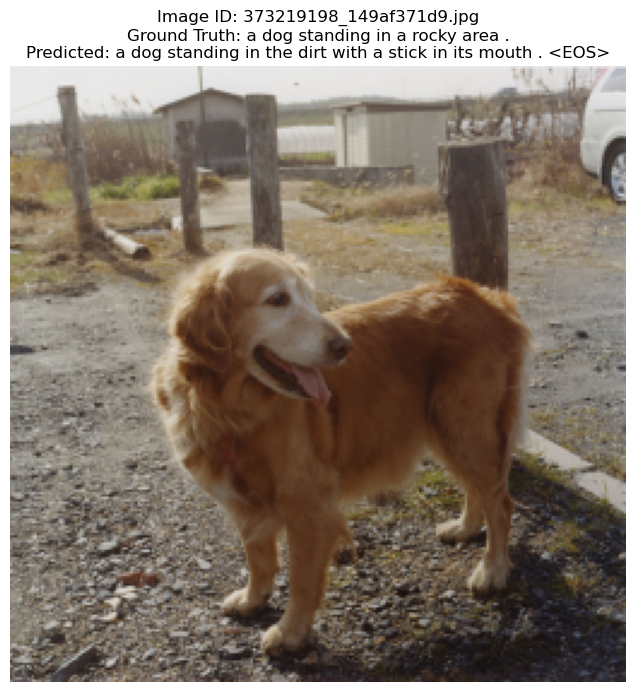

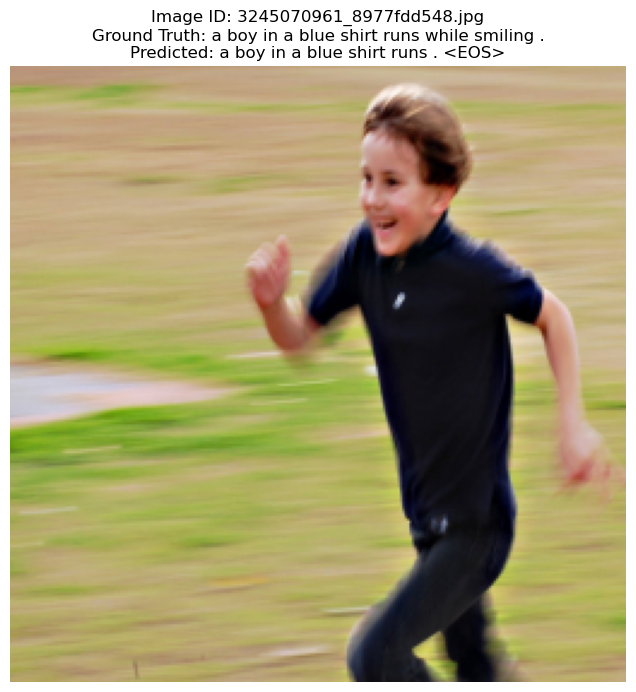

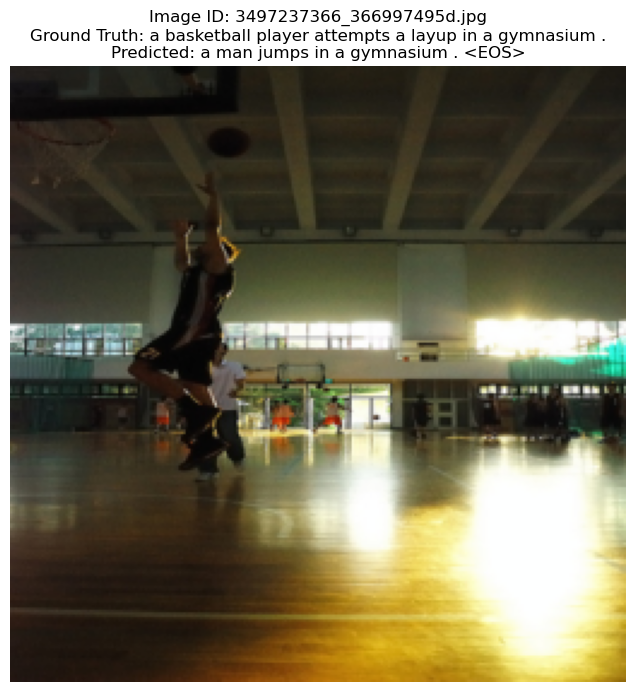

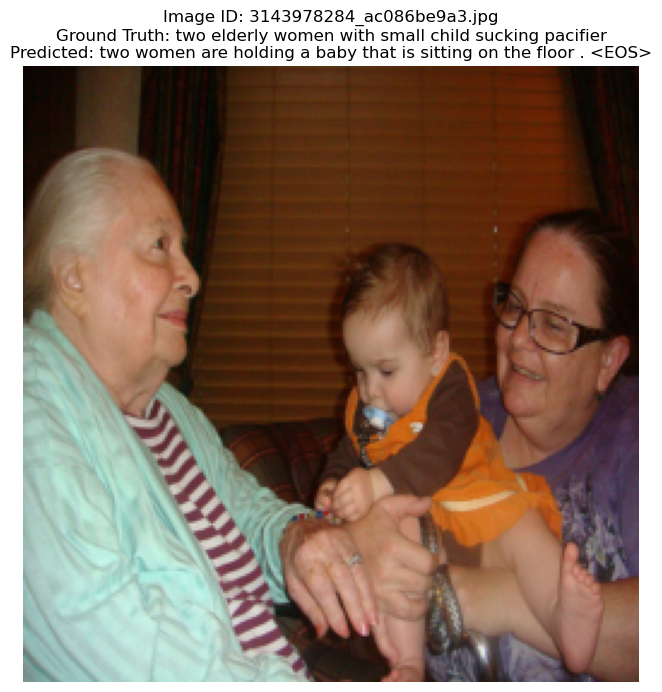

100%|██████████| 51/51 [02:11<00:00,  2.58s/it]


Evaluated on 1619 images from the validation set.
BLEU Score: 40.02%


In [2]:
#!/usr/bin/env python
# coding: utf-8

import os
import random
import torch
import torchvision
import torch.nn as nn
import numpy as np
import nltk
import matplotlib.pyplot as plt

from PIL import Image
from collections import Counter
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Define Vocabulary Class
class Vocabulary:
    def __init__(self):
        self.itos = {}
        self.stoi = {}
        self.itos[0] = "<PAD>"
        self.itos[1] = "<SOS>"
        self.itos[2] = "<EOS>"
        self.itos[3] = "<UNK>"
        self.stoi = {v: k for k, v in self.itos.items()}
    
    def __len__(self):
        return len(self.itos)
    
    def build_vocab(self, sentences, freq_threshold=5):
        frequencies = Counter()
        idx = len(self.itos)
        for sentence in sentences:
            tokens = word_tokenize(sentence.lower())
            frequencies.update(tokens)
        for word, freq in frequencies.items():
            if freq >= freq_threshold:
                if word not in self.stoi:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

# Define Pyramid Pooling Module
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super(PyramidPooling, self).__init__()
        self.pools = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1),
                nn.ReLU(inplace=True)
            )
            for pool_size in pool_sizes
        ])
    
    def forward(self, x):
        size = x.size()[2:]
        out = [x]
        for pool in self.pools:
            pooled = pool(x)
            upsampled = nn.functional.interpolate(pooled, size=size, mode='bilinear', align_corners=False)
            out.append(upsampled)
        return torch.cat(out, dim=1)

# Define Encoder
class P2TEncoder(nn.Module):
    def __init__(self, embed_size):
        super(P2TEncoder, self).__init__()
        backbone = torchvision.models.resnet50(pretrained=True)
        modules = list(backbone.children())[:-2]
        self.backbone = nn.Sequential(*modules)
        self.ppm = PyramidPooling(in_channels=2048, pool_sizes=[1, 2, 3, 6])
        self.conv = nn.Conv2d(2048 + 2048 // 4 * 4, embed_size, kernel_size=1)
        self.bn = nn.BatchNorm2d(embed_size)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, images):
        features = self.backbone(images)
        features = self.ppm(features)
        features = self.conv(features)
        features = self.bn(features)
        features = self.relu(features)
        batch_size, embed_size, h, w = features.size()
        features = features.view(batch_size, embed_size, -1)
        features = features.permute(0, 2, 1)
        return features

# Define Decoder
class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, heads, forward_expansion, dropout, max_len=100):
        super(CaptionDecoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_len, embed_size)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, nhead=heads, dim_feedforward=forward_expansion*embed_size, dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.embed_size = embed_size
        self.max_len = max_len
        
    def forward(self, features, captions):
        batch_size, seq_length = captions.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(features.device)
        captions = self.word_embedding(captions) + self.position_embedding(positions)
        captions = captions.permute(1, 0, 2)
        features = features.permute(1, 0, 2)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(features.device)
        output = self.transformer_decoder(tgt=captions, memory=features, tgt_mask=tgt_mask)
        output = output.permute(1, 0, 2)
        outputs = self.fc_out(output)
        return outputs

# Combine Encoder and Decoder
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, heads, forward_expansion, dropout):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = P2TEncoder(embed_size)
        self.decoder = CaptionDecoder(
            embed_size, vocab_size, num_layers, heads, forward_expansion, dropout
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Load the saved model and vocabulary
MODEL_PATH = 'image_captioning_modelv2.pth'
checkpoint = torch.load(MODEL_PATH, map_location='cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab = checkpoint['vocab']
model = ImageCaptioningModel(
    embed_size=512,
    vocab_size=len(vocab),
    num_layers=3,
    heads=8,
    forward_expansion=4,
    dropout=0.1
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

# Load captions
def load_captions(captions_file):
    captions = {}
    with open(captions_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue  # Skip empty lines
            tokens = line.split(',', 1)
            if len(tokens) < 2:
                print(f"Skipping line {line_number}: '{line}' (unexpected format)")
                continue
            image_id, caption = tokens[0], tokens[1]
            image_id = image_id.strip()
            caption = caption.strip()
            captions.setdefault(image_id, []).append(caption.lower())
    return captions

# Paths to the dataset
DATA_DIR = r'C:\UTA Curriculum\Sem 4\ML\Flickr8k_Kaggle\Images'
CAPTIONS_FILE = r'C:\UTA Curriculum\Sem 4\ML\Flickr8k_Kaggle\captions.txt'

# Load dataset
captions_dict = load_captions(CAPTIONS_FILE)

# Build the dataset
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_dict, transform=None, vocab=None):
        self.root_dir = root_dir
        self.captions_dict = captions_dict
        self.transform = transform
        
        self.image_ids = list(captions_dict.keys())
        
        if vocab is None:
            self.vocab = Vocabulary()
            # Build vocabulary from all captions
            all_captions = []
            for captions in captions_dict.values():
                all_captions.extend(captions)
            self.vocab.build_vocab(all_captions)
        else:
            self.vocab = vocab
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        captions = self.captions_dict[image_id]
        image_path = os.path.join(self.root_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, captions, image_id

# Create the dataset
dataset = FlickrDataset(root_dir=DATA_DIR, captions_dict=captions_dict, transform=transform, vocab=vocab)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Set random seed before splitting
torch.manual_seed(seed)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create training and validation captions dictionaries
train_captions_dict = {}
val_captions_dict = {}

for idx in train_dataset.indices:
    image_id = dataset.image_ids[idx]
    train_captions_dict[image_id] = captions_dict[image_id]

for idx in val_dataset.indices:
    image_id = dataset.image_ids[idx]
    val_captions_dict[image_id] = captions_dict[image_id]

# Update val_dataset to use val_captions_dict
val_dataset = FlickrDataset(root_dir=DATA_DIR, captions_dict=val_captions_dict, transform=transform, vocab=vocab)

# DataLoader
def collate_fn(batch):
    images, captions_list, image_ids = zip(*batch)
    images = torch.stack(images, 0)
    return images, captions_list, image_ids

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Function to generate caption
def generate_caption(model, image, vocab, max_length=50):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        outputs = torch.tensor([[vocab.stoi["<SOS>"]]]).to(device)
        for _ in range(max_length):
            predictions = model.decoder(features, outputs)
            predicted_id = predictions[:, -1, :].argmax(1)
            outputs = torch.cat([outputs, predicted_id.unsqueeze(1)], dim=1)
            if predicted_id.item() == vocab.stoi["<EOS>"]:
                break
        caption = [vocab.itos[idx.item()] for idx in outputs.squeeze()][1:]
        return ' '.join(caption)

# Evaluate the model and calculate BLEU score and accuracy
def evaluate_model(model, vocab, data_loader, num_images=10):
    model.eval()
    references = []
    hypotheses = []
    images_displayed = 0
    total_images = 0

    for images, captions_list, image_ids in tqdm(data_loader):
        images = images.to(device)
        batch_size = images.size(0)
        for i in range(batch_size):
            image = images[i]
            image_id = image_ids[i]
            ground_truth_captions = captions_list[i]
            generated_caption = generate_caption(model, image, vocab)
            
            # Tokenize the ground truth captions
            ground_truth_tokens = [word_tokenize(caption.lower()) for caption in ground_truth_captions]
            predicted_tokens = word_tokenize(generated_caption.lower())
            references.append(ground_truth_tokens)
            hypotheses.append(predicted_tokens)
            
            # Display the image with ground-truth and predicted captions
            if images_displayed < num_images:
                # Move the image tensor to CPU and convert to numpy
                img = image.cpu().permute(1, 2, 0).numpy()
                # Denormalize the image
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                
                # Plot the image and captions
                plt.figure(figsize=(8, 8))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Image ID: {image_id}\nGround Truth: {ground_truth_captions[0]}\nPredicted: {generated_caption}")
                plt.show()
                
                images_displayed += 1
            total_images += 1

    # Calculate BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"Evaluated on {total_images} images from the validation set.")
    print(f"BLEU Score: {bleu_score * 100:.2f}%")

# Call the evaluation function
evaluate_model(model, vocab, val_loader, num_images=10)


# Using Model "image_captioning_modelv2" on test image

C:\Users\prana\AppData\Local\Temp\ipykernel_22556\2421299668.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location='cpu')


Generated Caption: a girl in jeans is walking along the sidewalk . <EOS>


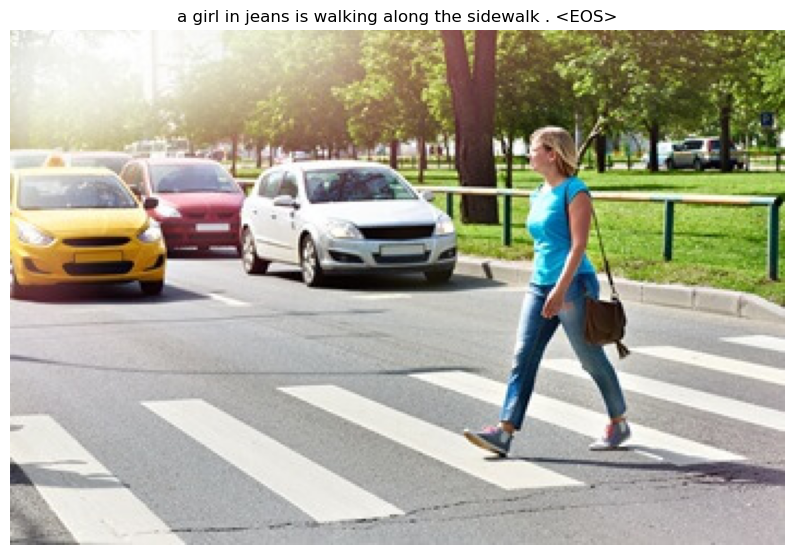

In [4]:
#!/usr/bin/env python
# coding: utf-8

import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from nltk.tokenize import word_tokenize

# Define the Vocabulary Class
class Vocabulary:
    def __init__(self):
        self.itos = {}
        self.stoi = {}
        self.itos[0] = "<PAD>"
        self.itos[1] = "<SOS>"
        self.itos[2] = "<EOS>"
        self.itos[3] = "<UNK>"
        self.stoi = {v: k for k, v in self.itos.items()}
    
    def __len__(self):
        return len(self.itos)

# Define Pyramid Pooling Module
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super(PyramidPooling, self).__init__()
        self.pools = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(pool_size),
                nn.Conv2d(in_channels, in_channels // len(pool_sizes), kernel_size=1),
                nn.ReLU(inplace=True)
            )
            for pool_size in pool_sizes
        ])
    
    def forward(self, x):
        size = x.size()[2:]
        out = [x]
        for pool in self.pools:
            pooled = pool(x)
            upsampled = nn.functional.interpolate(pooled, size=size, mode='bilinear', align_corners=False)
            out.append(upsampled)
        return torch.cat(out, dim=1)

# Define Encoder
class P2TEncoder(nn.Module):
    def __init__(self, embed_size):
        super(P2TEncoder, self).__init__()
        backbone = torchvision.models.resnet50(pretrained=True)
        modules = list(backbone.children())[:-2]
        self.backbone = nn.Sequential(*modules)
        self.ppm = PyramidPooling(in_channels=2048, pool_sizes=[1, 2, 3, 6])
        self.conv = nn.Conv2d(2048 + 2048 // 4 * 4, embed_size, kernel_size=1)
        self.bn = nn.BatchNorm2d(embed_size)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, images):
        features = self.backbone(images)
        features = self.ppm(features)
        features = self.conv(features)
        features = self.bn(features)
        features = self.relu(features)
        batch_size, embed_size, h, w = features.size()
        features = features.view(batch_size, embed_size, -1)
        features = features.permute(0, 2, 1)
        return features

# Define Decoder
class CaptionDecoder(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, heads, forward_expansion, dropout, max_len=100):
        super(CaptionDecoder, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_len, embed_size)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size, nhead=heads, dim_feedforward=forward_expansion*embed_size, dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        batch_size, seq_length = captions.size()
        positions = torch.arange(0, seq_length).unsqueeze(0).repeat(batch_size, 1).to(features.device)
        captions = self.word_embedding(captions) + self.position_embedding(positions)
        captions = captions.permute(1, 0, 2)
        features = features.permute(1, 0, 2)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_length).to(features.device)
        output = self.transformer_decoder(tgt=captions, memory=features, tgt_mask=tgt_mask)
        output = output.permute(1, 0, 2)
        outputs = self.fc_out(output)
        return outputs

# Combine Encoder and Decoder
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, heads, forward_expansion, dropout):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = P2TEncoder(embed_size)
        self.decoder = CaptionDecoder(
            embed_size, vocab_size, num_layers, heads, forward_expansion, dropout
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Load the saved model and vocabulary
MODEL_PATH = 'image_captioning_modelv2.pth'
checkpoint = torch.load(MODEL_PATH, map_location='cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab = checkpoint['vocab']

# Add __len__ method to the vocabulary object
vocab_size = len(vocab)

model = ImageCaptioningModel(
    embed_size=512,
    vocab_size=vocab_size,
    num_layers=3,
    heads=8,
    forward_expansion=4,
    dropout=0.1
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

# Function to generate caption
def generate_caption(model, image, vocab, max_length=50):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = model.encoder(image)
        outputs = torch.tensor([[vocab.stoi["<SOS>"]]]).to(device)
        for _ in range(max_length):
            predictions = model.decoder(features, outputs)
            predicted_id = predictions[:, -1, :].argmax(1)
            outputs = torch.cat([outputs, predicted_id.unsqueeze(1)], dim=1)
            if predicted_id.item() == vocab.stoi["<EOS>"]:
                break
        caption = [vocab.itos[idx.item()] for idx in outputs.squeeze()][1:]
        return ' '.join(caption)

# Main script for personal image usage
if __name__ == "__main__":
    image_path = "test.jpeg"  # Use test1.jpg which is in the same directory

    # Load the image
    image = Image.open(image_path).convert("RGB")
    image_transformed = transform(image)

    # Generate caption
    caption = generate_caption(model, image_transformed, vocab)
    print(f"Generated Caption: {caption}")

    # Display the image with the generated caption
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(caption)
    plt.axis('off')
    plt.show()